# TP 1 - Algorithme de rétro-propagation de l’erreur

**L’objectif de cette première séance de travaux pratiques est de vous faire implémenter par vous même l’apprentissage de réseaux de neurones simples.**
Cettre prise en main sera très formatrice pour utiliser des modèles plus évolués, et comprendre le fonctionnement des libaries (comme Keras) où l’apprentissage est automatisé.

On va travailler avec la base de données image MNIST, constituée d’images de
caractères manuscrits (60000 images en apprentissage, 10000 en test).

Voici un bout de code pour récupérer les données  :

## Exercice 0 : visualisation de quelques images de la base
<dl style='margin: 20px 0;'>
<dt>Nous commencerons par afficher les 200 premières images de la base d’apprentissage.</dt>
<dd>
    
- Écrire un script qui récupère les données avec le code précédent.  
- Compléter pour permettre l’affichage demandé en utilisant le code suivant :  

In [2]:
!pip3 install -U tensorflow keras h5py scipy sklearn matplotlib pandas nltk pillow

  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2959 sha256=86a83169a11ce69a2c16ad4fec697b52b4caf5e7732fb40c85ce3f293415f85a
  Stored in directory: c:\users\mehdi\appdata\local\pip\cache\wheels\f8\e0\3d\9d0c2020c44a519b9f02ab4fa6d2a4a996c98d79ab2f569fa1
Successfully built sklearn
  Attempting uninstall: h5py
    Found existing installation: h5py 3.6.0
    Uninstalling h5py-3.6.0:
      Successfully uninstalled h5py-3.6.0
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.0.1
    Uninstalling Pillow-9.0.1:
      Successfully uninstalled Pillow-9.0.1
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
  Attempting uninstall: pandas
    Found existing installation: pandas 1.4.2
    Uninstalling pandas-1.4.2:
      Successfully uninstalled pandas-1.4.2
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Unin

In [3]:
from keras.datasets import mnist
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

11490434/11490434 [==============================] - 7s 1us/step
60000 train samples
10000 test samples


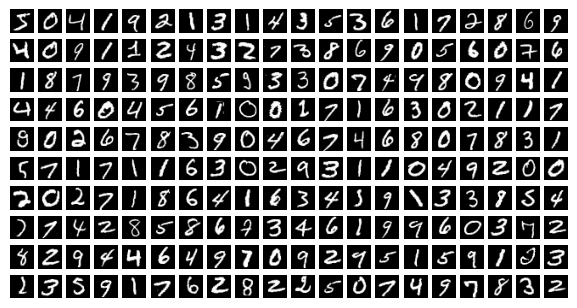

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.figure(figsize=(7.195, 3.841), dpi=100)
for i in range(200):
  plt.subplot(10,20,i+1)
  plt.imshow(X_train[i,:].reshape([28,28]), cmap='gray')
  plt.axis('off')
plt.show()

## Question :

Quel est l’espace dans lequel se trouvent les images ? Quel est sa taille ?

Les images sont des flotants, 28*28

## Exercice 1 : Régression Logistique

### Modèle de prédiction


<dl style='margin: 20px 0;'>
<dt>On va d’abord commencer par créer un modèle de classification linéaire populaire, la régression logistique.</dt>
<dd>
Ce modèle correspond à un réseau de neurones à une seule couche, qui va projeter le vecteur d’entrée $ \mathbf{x_i} $ pour une image MNIST
(taille $ 28^2=784 $) avec un vecteur de de paramètres $ \mathbf{w_{c}} $ pour chaque classe (plus un biais $ b_c $).
Pour correspondre à la matrice des données de l’exercice précédent, on considère que chaque exemple $ \mathbf{x_i} $ est un vecteur ligne - taille (1,784).
En regroupant l’ensemble des jeux de paramètres $ \mathbf{w_{c}} $ pour les 10 classes dans une matrice $ \mathbf{W} $ (taille $ 784\times 10 $),
et les biais dans un vecteur $ \mathbf{b} $, on obtient un vecteur
$ \mathbf{\hat{s_i}} =\mathbf{x_i}  \mathbf{W}  + \mathbf{b} $ de taille (1,10).
Une fonction d’activation de type soft-max sur $ \mathbf{\hat{y_i}} = $ `softmax` $ (\mathbf{s_i}) $ permet d’obtenir le vecteur de sortie prédit par le modèle $ \mathbf{\hat{y_i}} $
- de taille (1,10) - qui représente la probabilité *a posteriori*
$ p(\mathbf{\hat{y_i}} | \mathbf{x_i}) $ pour chacune des 10 classes:

</dd>

</dl>


<a id='equation-softmax'></a>
$$
p(\hat{y_{c,i}} | \mathbf{x_i}) ) = \frac{e^{\langle \mathbf{x_i} ; \mathbf{w_{c}}\rangle + b_{c}}}{\sum\limits_{c'=1}^{10} e^{\langle \mathbf{x_i} ; \mathbf{w_{c'}}\rangle + b_{c'}}} \tag{1}
$$

Le schéma ci-dessous illustre le modèle de régression logistique avec un réseau de neurones.

<img src="http://cedric.cnam.fr/~thomen/cours/US330X/_images/LR.png" style="height:150px;" align="center">

- Quel est le nombre de paramètres du modèle ? Justifier le calcul.  

### Formulation du problème d’apprentissage

> Afin d’entraîner le réseau de neurones, on va comparer, pour chaque exemple d’apprentissage, la sortie prédite $ \mathbf{\hat{y_i}} $ par le réseau
(équation [(1)](#equation-softmax)) pour l’image $ \mathbf{x_i} $, avec la sortie
réelle $ \mathbf{y_i^*} $ issue de la supervision qui correspond à la catégorie de l’image $ \mathbf{x_i} $:
on utilisera en encodage de type « one-hot » pour $ \mathbf{y_i^*} $, *i.e.* :



<a id='equation-one-hot'></a>
$$
y_{c,i}^* =
 \begin{cases}
   1 & \text{si c correspond à l'indice de la classe de } \mathbf{x_i}  \\
   0 & \text{sinon}
 \end{cases} \tag{2}
$$

Pour mesurer l’erreur de prédiction, on utilisera une fonction de coût de type entropie croisée (« cross-entropy ») entre $ \mathbf{\hat{y_i}} $ et $ \mathbf{y_i^*} $
(l’entropie croisée est lié à la divergence de Kullback-Leiber, qui mesure une dissimilarité entre distributions de probabilités) :
$ \mathcal{L}(\mathbf{\hat{y_i}}, \mathbf{y_i^*}) = -\sum\limits_{c=1}^{10} y_{c,i}^* log(\hat{y}_{c,i}) = - log(\hat{y}_{c^*,i}) $, où $ c^* $ correspond à l’indice de la classe donné par la supervision pour l’image $ \mathbf{x_i} $.

La fonction de coût finale consistera à moyenner l’entropie croisée sur l’ensemble de la base d’apprentissage $ \mathcal{D} $ consistuée de $ N=60000 $ images :


<a id='equation-ce'></a>
$$
\mathcal{L}_{\mathbf{W},\mathbf{b}}(\mathcal{D})  = - \frac{1}{N}\sum_{i=1}^{N} log(\hat{y}_{c^*,i}) \tag{3}
$$

### Question :

La fonction de coût de l’Eq. [(3)](#equation-ce) est-elle convexe par rapports aux paramètres $ \mathbf{W} $, $ \mathbf{b} $ du modèle ? Avec un pas de gradient bien choisi, peut-on assurer la convergence vers le minimum  global de la solution ?

### Optimisation du modèle

Afin d’optimiser les paramètres $ \mathbf{W} $ et $ \mathbf{b} $ du modèle de régression logistique par descente de gradient, on va utiliser la règle des dérivées chaînées (chain rule) :

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{W}} =  \frac{1}{N}\sum_{i=1}^{N} \frac{\partial \mathcal{L}}{\partial \mathbf{\hat{y_i}}}  \frac{\partial \mathbf{\hat{y_i}}}{\partial \mathbf{s_i}} \frac{\partial \mathbf{s_i}}{\partial \mathbf{W}}
$$

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{b}} =  \frac{1}{N}\sum_{i=1}^{N} \frac{\partial \mathcal{L}}{\partial \mathbf{\hat{y_i}}}  \frac{\partial \mathbf{\hat{y_i}}}{\partial \mathbf{s_i}} \frac{\partial \mathbf{s_i}}{\partial \mathbf{b}}
$$

### Montrer que :

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{s_i}} = \mathbf{\delta^y_i}  =\frac{\partial \mathcal{L}}{\partial \mathbf{\hat{y_i}}}  \frac{\partial \mathbf{\hat{y_i}}}{\partial \mathbf{s_i}} = \mathbf{\hat{y_i}} - \mathbf{y_i^*}
$$

### En déduire que les gradients de $ \mathcal{L} $ par rapport aux paramètres du modèle s’écrivent :


<a id='equation-gradientw-LR'></a>
$$
\frac{\partial \mathcal{L}}{\partial \mathbf{W}} = \frac{1}{N} \mathbf{X}^T (\mathbf{\hat{Y}} - \mathbf{Y^*}) = \frac{1}{N} \mathbf{X}^T \mathbf{\Delta^y} \tag{4}
$$


<a id='equation-gradientb-LR'></a>
$$
\frac{\partial \mathcal{L}}{\partial \mathbf{b}} = \frac{1}{N}\sum_{i=1}^{N}(\mathbf{\hat{y_i}} - \mathbf{y_i^*}) \tag{5}
$$

Où  $ \mathbf{X} $ est la matrice des données (taille $ 60000\times 784 $), $ \mathbf{\hat{Y}} $ est la matrice des labels prédits sur l’ensemble de la base d’apprentissage (taille $ 60000\times 10 $)
et $ \mathbf{Y^*} $ est la matrice des labels donnée issue de la supervision (« ground truth », taille $ 60000\times 10 $), et $ \mathbf{\Delta^y}=\mathbf{\hat{Y}}-\mathbf{Y^*} $.

### Implémentation de l’apprentissage

Les gradients aux équations [(4)](#equation-gradientw-LR) et [(5)](#equation-gradientb-LR) s’écrivent sous forme « vectorielle », ce qui va rendre les calculs efficaces avec des librairies de calculs scientifique comme `numpy`. Après calcul du gradient, les paramètres
seront mis à jour de la manière suivante :


<a id='equation-gradientupdatew'></a>
$$
\mathbf{W}^{(t+1)} = \mathbf{W}^{(t)} - \eta \frac{\partial \mathcal{L}}{\partial \mathbf{W}} \tag{6}
$$


<a id='equation-gradientupdateb'></a>
$$
\mathbf{b}^{(t+1)} = \mathbf{b}^{(t)} - \eta \frac{\partial \mathcal{L}}{\partial \mathbf{b}} \tag{7}
$$

où $ \eta $ est le pas de gradient (learning rate).

Pour implémenter l’algorithme d’apprentissage, on utuilisera une descente de gradient stochastique, c’est à dire que les gradients aux équations [(4)](#equation-gradientw-LR) et [(5)](#equation-gradientb-LR)  ne seront pas calculés
sur l’ensemble des $ N=60000 $ images d’apprentissage, mais sur un sous ensemble appelé **batch**. Cette technique permet une mise à jour des paramètres plus fréquente qu’avec une descente de gradient classique, et une convergence
plus rapide (au détriment d’un calcul de gradient approximé).

**On demande de mettre en place un script** `exo1.py` **qui implémente l’alogorithme de régression logistique sur la base MNIST.**

Après avoir chargé les données (exercice 0), on utilisera le code suivant pour générer des labels au format
0-1 encoding - équation [(2)](#equation-one-hot).

In [24]:
from keras.utils import np_utils
K=10
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, K)
Y_test = np_utils.to_categorical(y_test, K)

**On pourra utiliser la fonction suivante pour calculer la fonction softmax sur chaque élément de de la matrice de la projection linéraire (taille 𝑡𝑏×10) :**

In [25]:
def softmax(X):
    # Input matrix X of size Nbxd - Output matrix of same size
    E = np.exp(X)
    return (E.T / np.sum(E,axis=1)).T

In [26]:
def forward (x,w,b) : 
    s= np.dot(x,w)+b
    y=softmax(s)
    return y 
def backward (x,y,eta,w,b,yc):
    N= batch_size 
    
    dw= (np.dot(x.T,yc-y))/N

    db= np.sum(yc-y)/N
    w=w-eta*dw
    b=b-eta*db
    return w, b
        

## On mettra alors en place un code dont le squellette est donné ci-dessous :

In [32]:
import numpy as np 
N = X_train.shape[0]
d = X_train.shape[1]
w = np.zeros((d,K))
b = np.zeros((1,K))
numEp = 20 # Number of epochs for gradient descent
eta = 1e-1 # Learning rate
batch_size = 100
nb_batches = int(float(N) / batch_size)
gradW = np.zeros((d,K))
gradb = np.zeros((1,K))

for epoch in range(numEp):
    for ex in range(nb_batches):
        # FORWARD PASS : compute prediction with current params for examples in batch
        yc=forward(X_train[ex*batch_size:(ex+1)*batch_size],w,b)
        w,b = backward (X_train[ex*batch_size:(ex+1)*batch_size],Y_train[ex*batch_size:(ex+1)*batch_size],eta,w,b,yc)
            
        # BACKWARD PASS :
        # 1) compute gradients for W and b
        # 2) update W and b parameters with gradient descent

Pour compléter ce code, vous devez :

- Mettre en place une fonction `forward(batch, W, b)` qui va calculer la prédiction pour un batch de données. La fonction `forward` sera appelée pour chaque itération de la double boucle précédente.  


> - Si on considère un batch des données de taille $ tb\times 784 $, les paramètres $ \mathbf{W} $ (taille $ 784\times 10 $) et $ \mathbf{b} $ (taille $ 1\times 10 $), la fonction `forward` renvoie la prédiction $ \mathbf{\hat{Y}} $ sur le batch (taille $ tb\times 10 $).    

- Compléter le code pour la passe backward, consistant à  :
  - Calculer les gradient comme indiqué aux équations [(4)](#equation-gradientw-LR) et [(5)](#equation-gradientb-LR).
  - Mettre à jour les paramètres par descente de gradient comme indiqué aux équations [(6)](#equation-gradientupdatew) et [(7)](#equation-gradientupdateb).  


Enfin vous pouvez utiliser la fonction `accuracy(W, b, images, labels)` fournie pour calculer le taux de bonne reconnaissance du modèle. Ceci permettra de mesurer l’évolution des performances au cours des époques de l’algorithme d’apprentissage, et sur la base de test une fois le modèle appris.

### Vous devez obtenir un score de l’ordre de 92% sur la base de test pour ce modèle de régression logistique.

In [35]:
def accuracy(W, b, images, labels):
  pred = forward(images, W,b )
  return np.where( pred.argmax(axis=1) != labels.argmax(axis=1) , 0.,1.).mean()*100.0

In [36]:
accuracy(w, b, X_test, Y_test)

92.13

## Exercice 2 : Perceptron multi-couches (MLP)

### L’objectif de ce second exercice est d’étendre le modèle de régression logistique afin de mettre en place des modèles de prédictions plus riches.
**En particulier, on va s’intéresser aux Perceptron multi-couches (Multi-Layer Percpetron, MLP)**. Contrairement à la régression logistique qui se limite à des séparateurs linéaires,
le Perceptron permet l’apprentissage de frontières de décisions non linéaires, et constituent des approximateurs universels de fonctions.

L’objectif de la séance de travaux pratiques est de mettre en place le code pour effectuer des prédictions et entraîner un Perceptron à une couche cachée.

### Prédiction avec un Perceptron (Forward)

L’architecture du perpcetron à une couche cachée est montrée à la figure ci-dessous.

<img src="http://cedric.cnam.fr/~thomen/cours/US330X/_images/MLP.png" style="height:250px;" align="center">

Si on considère les données de la base MNIST, chaque image est représentée par un vecteur de taille $ 28^2=784 $.
Le perpcetron va effecteur les différentes étape de transformation pour produire la prédiction finale, *i.e.* la catégorie sémantique de l’image :

- Une étape de projection linéaire, qui va projeter chaque image sur un vecteur de taille $ (1,L) $, *e.g.* $ L=100 $. En considérant chaque exemple $ \mathbf{x_i} $ est un vecteur ligne - taille $ (1,784) $ - la projection linéaire peut être représentée par la matrice $ \mathbf{W^h} $ (taille $ (784, L) $), et le vecteur de biais $ \mathbf{b^h} $ (taille $ (1, L) $) : $ \mathbf{\hat{u_i}} =\mathbf{x_i}  \mathbf{W^h}  + \mathbf{b^h} $.  


> - Une étape de non linéarité, *e.g.* de type sigmoïde :  $ \forall j \in  \left\lbrace 1; L \right\rbrace  ~ h_{i,j} = \frac{1}{1+exp(-u_{i,j})} $  



- Une seconde étape de projection linéaire, qui va projeter le vecteur latent de taille $ (1,L) $ sur un vecteur de taille $ (1,K)=10 $ (nombre de classes). Cette opération de projection linéaire sera représentée par la matrice $ \mathbf{W^y} $ (taille $ (L, K) $), et le vecteur de biais $ \mathbf{b^y} $ (taille $ (1, K) $) : $ \mathbf{\hat{v_i}} =\mathbf{h_i}  \mathbf{W^y}  + \mathbf{b^y} $.  


> - Une étape de non linéarité de type soft-max vue la semaine précédente pour la régression logistique : $ \forall j \in  \left\lbrace 1; K \right\rbrace  ~ y_{i,j} = \frac{exp(v_{i,j})}{\sum\limits_{i=1}^K exp(v_{i,k})} $  



**On demande de mettre en place un script** `mlp.py` **qui implémente l’alogorithme du Percpetron sur la base MNIST.**


<dl style='margin: 20px 0;'>
<dt>L’algorithme reprendra le squelette du code de la régression logistique. Pour adapter ce code pour le Perceptron pour la partie prédiction,  vous devez :</dt>
<dd>
- Modifier la fonction de prédiction, afin disposer la fonction `forward(batch, Wh, bh, Wy, by)` qui reverra à la fois la prédiction pour le batch ainsi que la matrice des couches latentes.  


> - Si on considère un batch des données de taille $ t_b\times 784 $, les paramètres $ \mathbf{W^h} $ (taille $ 784\times L $), $ \mathbf{b^h} $ (taille $ 1\times L $), $ \mathbf{W^y} $ (taille $ L\times K $) et $ \mathbf{b^y} $ (taille $ 1\times K $), la fonction `forward` renvoie la prédiction $ \mathbf{\hat{Y}} $ sur le batch (taille $ t_b\times K $) et la matrice de variables latentes (taille $ t_b\times L $).  



</dd>

</dl>

In [ ]:
# Function forward pour le MLP
def forward(batch, Wh, bh, Wy, by):                 
    latent = 0
    res = 0
    return latent, res

In [ ]:
# Calcul de l'accuracy avec le MLP
def accuracy(batch, labels,Wh, bh, Wy, by):
   latent, pred = forward(batch, Wh, bh, Wy, by)  
   return np.where( pred.argmax(axis=1) != labels.argmax(axis=1) , 0.,1.).mean()*100.0

### Apprentissage du Perceptron (Backward)

Afin d’entraîner le Perceptron, on va utiliser l’algorithme de rétro-propagation de l’erreur. On rappelle que pour chaque batch d’exemples, l’algorithme va effectuer une passe `forward` (Exercice 1), permettant de calculer la prédiction du réseau.
Une fonction de coût (ici l’entropie croisée) entre la sortie prédite et la la sortie donnée par la supervision va permettre de calculer le gradient de l’erreur par rapport à tous les paramètres paramètres du modèle, *i.e.* $ \mathbf{W^y} $ (taille $ (L, K) $), $ \mathbf{b^y} $ (taille $ (1, K) $), $ \mathbf{W^h} $ (taille $ (784, L) $), et $ \mathbf{b^h} $ (taille $ (1, L) $).

On rappelle les équation des gradients, effectuées depuis le haut vers le bas du réseau :

1. Mise à jour de $ \mathbf{W^y} $ et $ \mathbf{b^y} $ :  


$$
\frac{\partial \mathcal{L}}{\partial \mathbf{v_i}} = \mathbf{\delta^y_i} = \mathbf{\hat{y_i}} - \mathbf{y_i^*}
$$


<a id='equation-gradientw'></a>
$$
\frac{\partial \mathcal{L}}{\partial \mathbf{W^y}} = \frac{1}{t_b}\mathbf{H}^T (\mathbf{\hat{Y}} - \mathbf{Y^*}) = \frac{1}{t_b} \mathbf{H}^T \mathbf{\Delta^y} \tag{8}
$$


<a id='equation-gradientb'></a>
$$
\frac{\partial \mathcal{L}}{\partial \mathbf{b^y}} = \frac{1}{t_b}\sum_{i=1}^{t_b}(\mathbf{\hat{y_i}} - \mathbf{y_i^*}) \tag{9}
$$

Où  $ \mathbf{H} $ est la matrice des couches cachées sur le batch (taille $ t_b\times L $), $ \mathbf{\hat{Y}} $ est la matrice des labels prédits sur l’ensemble de la base d’apprentissage (taille $ t_b\times K $)
et $ \mathbf{Y^*} $ est la matrice des labels donnée issue de la supervision (« ground truth », taille $ t_b\times K $), et $ \mathbf{\Delta^y}=\mathbf{\hat{Y}}-\mathbf{Y^*} $.

1. Mise à jour de $ \mathbf{W^h} $ et $ \mathbf{b^h} $ :  


$$
\frac{\partial \mathcal{L}}{\partial \mathbf{u_i}} = \mathbf{\delta^h_i} = \mathbf{\delta^y_i} \mathbf{W^{y}}^T   \odot \sigma^{'}(\mathbf{u_i}) = \mathbf{\delta^y_i} \mathbf{W^{y}}^T \odot (\mathbf{h_i} \odot (1-\mathbf{h_i}))
$$

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{W^h}} =  \frac{1}{t_b} \mathbf{X}^T \mathbf{\Delta^h}
$$

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{b^h}} = \frac{1}{t_b}\sum_{i=1}^{t_b}(\delta^h_i)
$$

Où  $ \mathbf{X} $ est la matrice des données sur le batch (taille $ t_b\times 784 $), et $ \mathbf{\Delta^h} $ est la matrice des $ \delta^h_i $ sur le batch (taille $ t_b\times L $).

## Adapter la partie backward de l’algorithme pour entraîner le Perceptron.
On Choisira un pas de gradient $ \eta=1.0 $ et 100 époques.

In [ ]:
d = X_train.shape[1] # dimension d'entrée (784)
N = X_train.shape[0] # nombre d'exemples d'apprentissage (60000)
L=100 # dimension de l'espace latent 

# Initialisation des poids : Gaussienne ou Glorot (voir ci-dessous)  
Wh = 0
bh = 0
Wy = 0
by = 0

# Hyper-paramètres d'apprentissage
numEpochs = 50
eta = 1

batch_size = 100
nb_batches = int(float(N) / batch_size)

for it in range(numEpochs):
    for b in range(nb_batches):
        # FORWARD
        
        # BACKWARD 
        # Calcul de deltay = dE / dy~         
        # Calcul de gradWy = h^T * deltay - (LxN) * (NxK)  et gradby      
 
        # Calcul de  deltah   =dE / dh~ size (N,L)
        # Calcul de gradWh = x^T * deltah - (dxN) * (NxL) = (dxL) et gradbh
        
        # Mise à jour des poids du réseau
    
    print("epoch ", it, "accurcy train=",accuracy(X_train, Y_train, Wh, bh, Wy, by), "accurcy test=",accuracy(X_test, Y_test, Wh, bh, Wy, by))

## Questions :

- La fonction de coût de l’Eq. [(3)](tpDeepLearning1.ipynb#equation-ce) est-elle convexe par rapport aux paramètres $ \mathbf{W} $, $ \mathbf{b} $ du modèle ? Avec un pas de gradient bien choisi, peut-on assurer la convergence vers le minimum global de la solution ?  
- Tester en initialisant les matrices à 0 comme pour la régression logistique. Quelles performances obtenez-vous ? Que peut-on en conclure ?  
- Vous testerez deux autres initialisations : une qui initialise les poids avec une loi normale de moyenne nulle et d’écart type à fixer, *e.g.* $ 10^-1 $, et une autre connue sous le nom de Xavier [[GB10]](#glorot10understandingthe), qui divise la valeur de la gaussienne par $ \sqrt{ni} $, où $ ni $ est le nombre de neurone dans la couche d’entrée.  
- Évaluer les performances du modèle. **Vous devez obtenir un score de l’ordre de 98% sur la base de test pour ce réseau de neurones à une couche cachée.**  


<a id='glorot10understandingthe'></a>
\[GB10\] Xavier Glorot and Yoshua Bengio. Understanding the difficulty of training deep feedforward neural networks. In *In Proceedings of the International Conference on Artificial Intelligence and Statistics (AISTATS’10). Society for Artificial Intelligence and Statistics*. 2010.